# MS Fidelity Estimations for QSCOUT

In [1]:
import scipy.constants
from scipy.constants import physical_constants
import qutip as qtp
import numpy as np
from numpy import exp, sqrt, sin
from math import factorial
import itertools
from operator import mul, add
import matplotlib.pyplot as plt
import seaborn as sb
import ast

In [14]:
import importlib
import sys, os
from pathlib import Path
sys.path.append('/home/vikk/Documents/Research/sqrlab/MS Modes/XTalkRobustMS/tools/')
import IonChainTools as ict
import MSFidelityEstimation as msfe
importlib.reload(msfe)
from MSFidelityEstimation import *

In [3]:
π = np.pi

## QSCOUT parameters

In [4]:
# Ytterbium171
M=171*physical_constants['atomic mass constant'][0]

# Laser wavelength
# carrier_wavelen = # 355*1e-9 # 355nm, from "frequency robust ..." paper
# carrier_wavenum = 2*π/carrier_wavelen # Laser wavenumber (k)
# carrier_freq = scipy.constants.c*carrier_wavenum
qbit_splitting = 2*π*12.643*1e6 # qubit splitting, from "Engineering The ..." paper
raman_wavelen = 355*1e-9 # 355nm, from "frequency robust ..." paper
raman_freq = 2*π*scipy.constants.c/raman_wavelen
kvec = qbit_splitting/scipy.constants.c*np.sqrt(2)

# Rabi rate
Ωpeak = 2*π*190*1e3 # 190MHz, quoted in "Frequency-robust MS ..." paper

In [5]:
# Trap specifications
# Axial COM of 0.52MHz and highest radial mode of 2.296MHz are quoted in 
# "Frequency-robust Mølmer-Sørensen gates via balanced contributions of multiple motional modes"
νz = 2*π*0.52*1e6 # 0.52MHz
νr = 2*π*2.296*1e6 # 2.296MHz

In [6]:
# Optical Crosstalk, from "ENGINEERING THE QUANTUM SCIENTIFIC COMPUTING OPEN USER TESTBED"
# These values are scaled such that Ω=1 for the target ion
neighΩ = 0.0236 # Rabi frequency on neighbor of target ion
nneighΩ = 0.006 # Rabi frequency on next neighbor of target ion

In [7]:
# Blue and Red beam phases
# Below should implement X gate
ϕB = π/2
ϕR = π/2

In [8]:
N = 5
modetype="radial"
K = 1
τ = 200e-6 # 200μs

## Fidelity Calculations

In [9]:
N = 5
modetype="radial"
K = 1
τ = 200e-6 # 200μs

trapspec = TrapSpec(νz, νr)
devicespec = TIDeviceSpec(N, trapspec, qbit_splitting, raman_freq, M)

### Plot Generation Functions

In [10]:
def plotBestModes(N, fidarr, title=None):
    fig, axes = plt.subplots(2,3, figsize=(18,11), sharex=True, sharey=True)
    cbar_ax = fig.add_axes([.93, .3, .02, 0.5])
    cmap = sb.color_palette("rocket", as_cmap=True)
    for m in range(N):
        ax = axes.flat[m]
        annot = [[f"{m if m!=N-1 else 'COM'}" if (i==N//2 and j==N//2) else "" for i in range(N)] for j in range(N)]
        sb.heatmap(fidarr[:,:,m], ax=ax, vmin=0.94, vmax=1.0, cbar=(m==0),cbar_ax=None if m==1 else cbar_ax,
                   annot=annot, annot_kws={'c':'w', 'size':20}, fmt="", cmap=cmap,
                  xticklabels=[f"{i}" for i in range(N)])
        ax.set_yticklabels(ax.get_yticks(), size = 20)
        ax.set_xticklabels(ax.get_xticks(), size = 20)
    annot = [["" for i in range(N)] for j in range(N)]
    annot[N//2][N//2] = "Best"
    bestmodes = np.argmax(fidarr,2)
    bestfids = np.max(fidarr,2)
    for i in range(N):
        for j in range(i+1, N):
            annot[i][j] = f"{bestmodes[i,j]}"
            annot[j][i] = annot[i][j]
    ax_best = axes.flat[-1]
    sb.heatmap(bestfids, ax=ax_best, vmin=0.95, vmax=1.0, cbar=False,cbar_ax=cbar_ax,
              annot=annot, annot_kws={'c':'k', 'size':20}, fmt="", cmap=cmap)
    ax_best.set_xticklabels([f"{i}" for i in range(N)], size = 20)
    cbar_ax.figure.axes[-1].tick_params(labelsize=20)
    
    # bbox = ax_best.get_window_extent()
    # fig.patches.extend([plt.Rectangle((bbox.xmin, bbox.ymin),
    #                                   bbox.xmax-bbox.xmin, bbox.ymax-bbox.ymin,
    #                                   fill=True, color='g', alpha=0.7, zorder=-1, figure=fig)])
    
    fig.patches.extend([plt.Rectangle((985, 45),
                                      500, 460,
                                      fill=True, color='g', alpha=0.7, zorder=-1,
                                      transform=None, figure=fig)])
    
    ax_best.text(2.1, 2.6, "Best", c="w", size='20')
    if title!=None: fig.suptitle(title, size='25')

### Optical and Mode Crosstalk

In [11]:
fids = []
for targets, m in itertools.product(itertools.combinations(range(N),2), range(N)):
    ωd, Ω = calc_necessary_sideband_detuning_and_rabi_freq(devicespec, targets, m, modetype, τ, K=K)
    Ωvals = Ω*Ωvals_from_fixed_neighbor_xtalk(N, targets, neighΩ, nneighΩ)
    mslaserspec = MSLaserSpec(ωd, Ωvals, ϕB, ϕR)
    msopspec = MSOpSpec(devicespec, mslaserspec, τ, targets=targets, m=m, modetype=modetype, K=K)
    ρf = MS_Analytical_zeroinitalstate_tracemodes(msopspec, simmodes=list(range(N)),modetype=modetype, modetrunc=2)
    for fidions in itertools.combinations(range(N),2):
        ρred = ρf.ptrace(fidions)
        parity_curve_amplitude = 2*abs(ρred[3,0])
        pop00 = abs(ρred[0,0])
        pop11 = abs(ρred[3,3])
        measured_fid = (pop00 + pop11 + parity_curve_amplitude)/2
        fidcalc = MSFidCalculation(opspec=msopspec, method='MS_Analytical_zeroinitalstate_tracemodes', fid=measured_fid, fidions=fidions)
        fids.append(fidcalc)
file = open('calculated_results/qscout_5ion_fidelities_withopticalxtalk_withmodextalk', "w")
file.writelines([str(fidcalc)+'\n' for fidcalc in fids])

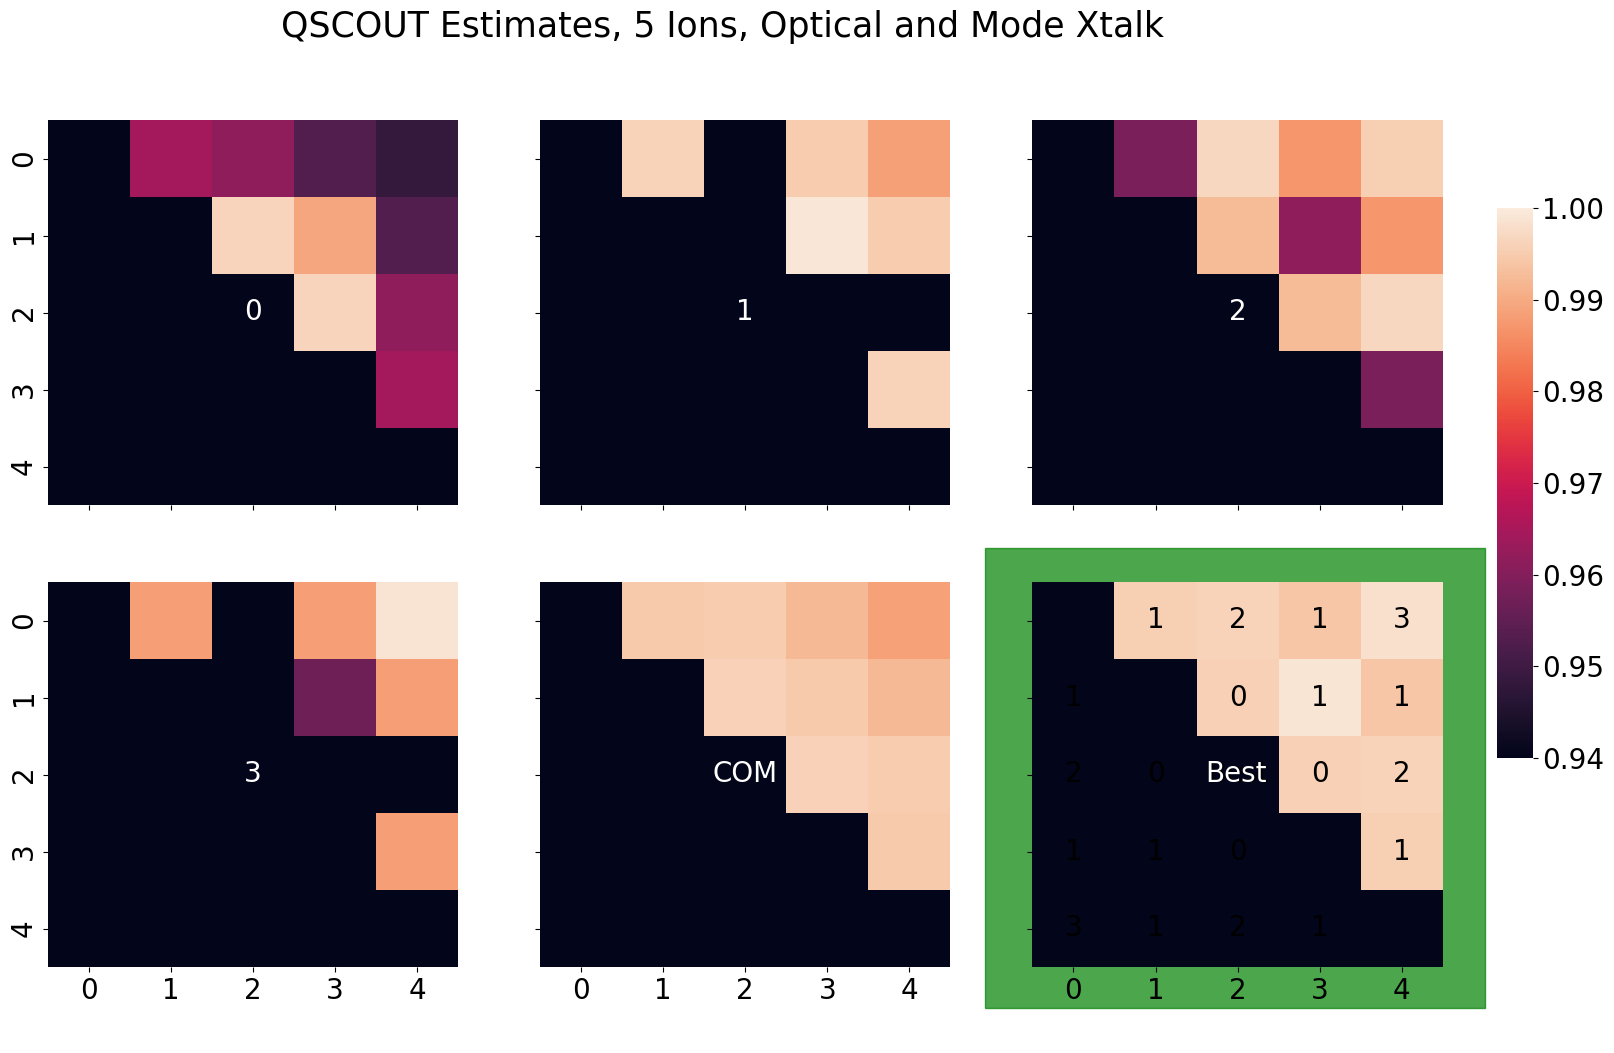

In [32]:
file = open('calculated_results/qscout_5ion_fidelities_withopticalxtalk_withmodextalk', "r")
fids = [MSFidCalculation.fromDict(ast.literal_eval(line)) for line in file.readlines()]
fidarr = np.zeros((N,N,N))
for fidcalc in fids:
    if fidcalc.fidions == fidcalc.opspec.targets:
        targets = fidcalc.opspec.targets
        m = fidcalc.opspec.m
        fidarr[targets[0],targets[1],m] = fidcalc.fid
plotBestModes(N, fidarr, title="QSCOUT Estimates, 5 Ions, Optical and Mode Xtalk")

### Optical Crosstalk, No Mode Crosstalk

In [33]:
fids = []
for targets, m in itertools.product(itertools.combinations(range(N),2), range(N)):
    ωd, Ω = calc_necessary_sideband_detuning_and_rabi_freq(devicespec, targets, m, modetype, τ, K=K)
    Ωvals = Ω*Ωvals_from_fixed_neighbor_xtalk(N, targets, neighΩ, nneighΩ)
    mslaserspec = MSLaserSpec(ωd, Ωvals, ϕB, ϕR)
    msopspec = MSOpSpec(devicespec, mslaserspec, τ, targets=targets, m=m, modetype=modetype, K=K)
    ρf = MS_Analytical_zeroinitalstate_tracemodes(msopspec, simmodes=[m],modetype=modetype, modetrunc=2)
    for fidions in itertools.combinations(range(N),2):
        ρred = ρf.ptrace(fidions)
        parity_curve_amplitude = 2*abs(ρred[3,0])
        pop00 = abs(ρred[0,0])
        pop11 = abs(ρred[3,3])
        measured_fid = (pop00 + pop11 + parity_curve_amplitude)/2
        fidcalc = MSFidCalculation(opspec=msopspec, method='MS_Analytical_zeroinitalstate_tracemodes', fid=measured_fid, fidions=fidions)
        fids.append(fidcalc)
file = open('calculated_results/qscout_5ion_fidelities_withopticalxtalk_withoutmodextalk', "w")
file.writelines([str(fidcalc)+'\n' for fidcalc in fids])

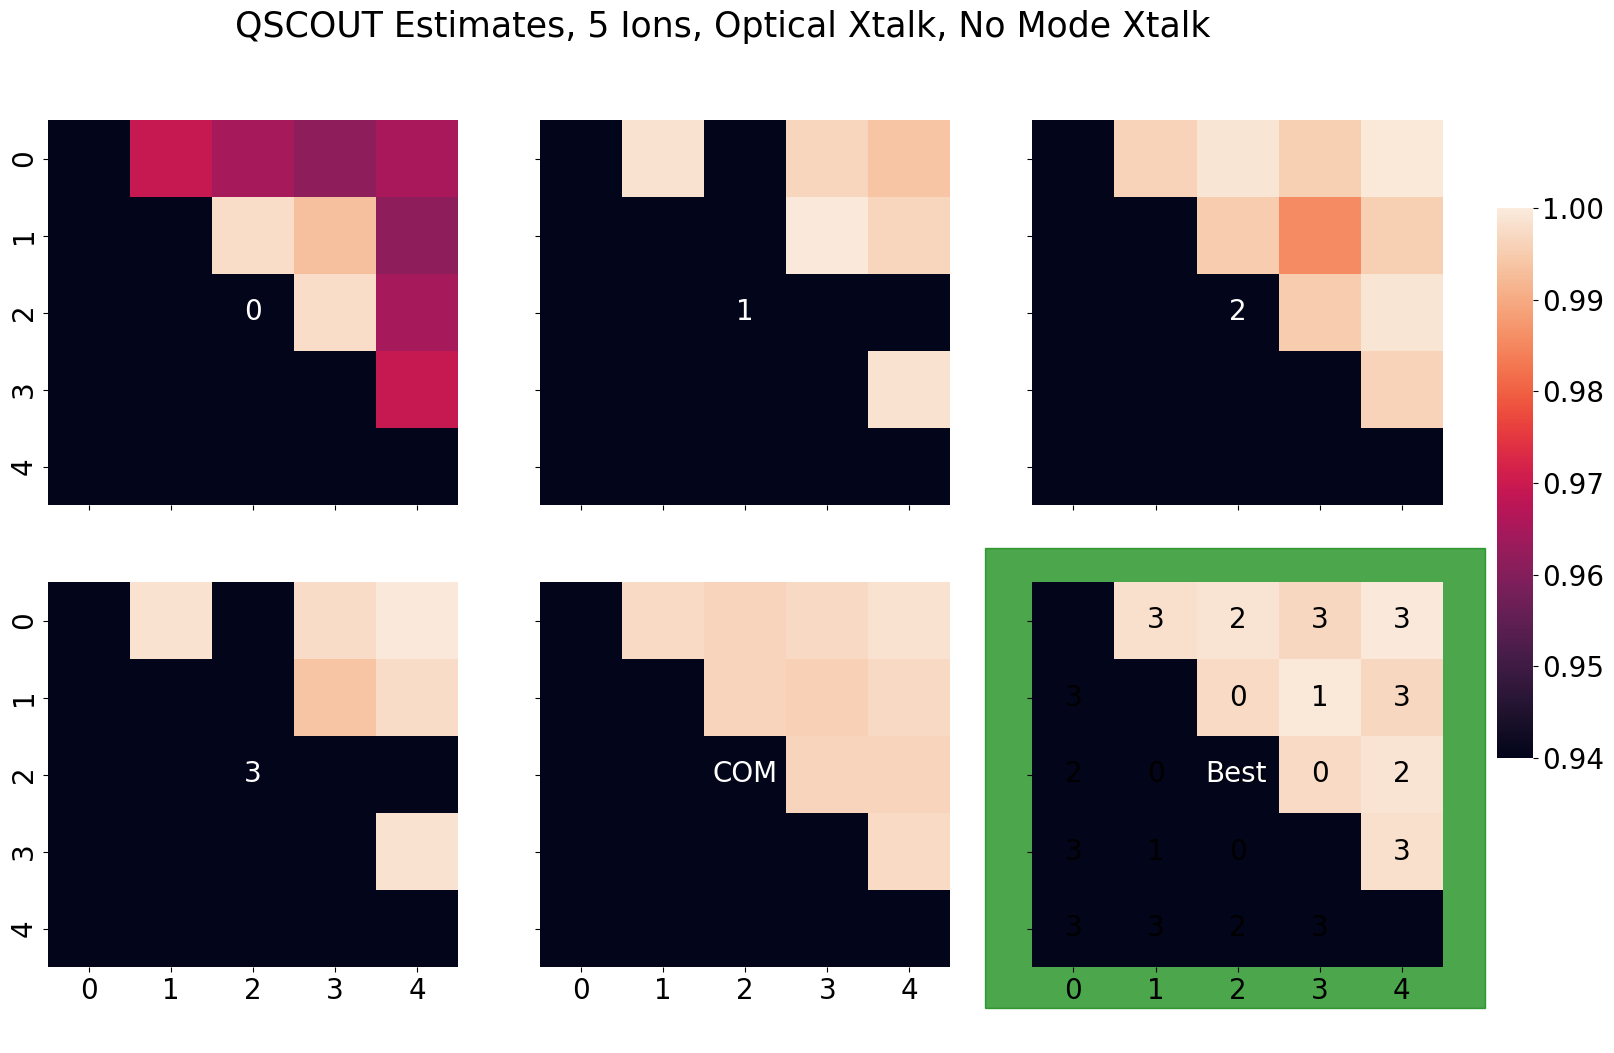

In [34]:
file = open('calculated_results/qscout_5ion_fidelities_withopticalxtalk_withoutmodextalk', "r")
fids = [MSFidCalculation.fromDict(ast.literal_eval(line)) for line in file.readlines()]
fidarr = np.zeros((N,N,N))
for fidcalc in fids:
    if fidcalc.fidions == fidcalc.opspec.targets:
        targets = fidcalc.opspec.targets
        m = fidcalc.opspec.m
        fidarr[targets[0],targets[1],m] = fidcalc.fid
plotBestModes(N, fidarr, title="QSCOUT Estimates, 5 Ions, Optical Xtalk, No Mode Xtalk")

### Mode Crosstalk, No Optical Crosstalk

In [35]:
fids = []
for targets, m in itertools.product(itertools.combinations(range(N),2), range(N)):
    ωd, Ω = calc_necessary_sideband_detuning_and_rabi_freq(devicespec, targets, m, modetype, τ, K=K)
    Ωvals = Ω*Ωvals_from_fixed_neighbor_xtalk(N, targets, 0, 0)
    mslaserspec = MSLaserSpec(ωd, Ωvals, ϕB, ϕR)
    msopspec = MSOpSpec(devicespec, mslaserspec, τ, targets=targets, m=m, modetype=modetype, K=K)
    ρf = MS_Analytical_zeroinitalstate_tracemodes(msopspec, simmodes=list(range(N)),modetype=modetype, modetrunc=2)
    for fidions in itertools.combinations(range(N),2):
        ρred = ρf.ptrace(fidions)
        parity_curve_amplitude = 2*abs(ρred[3,0])
        pop00 = abs(ρred[0,0])
        pop11 = abs(ρred[3,3])
        measured_fid = (pop00 + pop11 + parity_curve_amplitude)/2
        fidcalc = MSFidCalculation(opspec=msopspec, method='MS_Analytical_zeroinitalstate_tracemodes', fid=measured_fid, fidions=fidions)
        fids.append(fidcalc)
file = open('calculated_results/qscout_5ion_fidelities_withoutopticalxtalk_withmodextalk', "w")
file.writelines([str(fidcalc)+'\n' for fidcalc in fids])

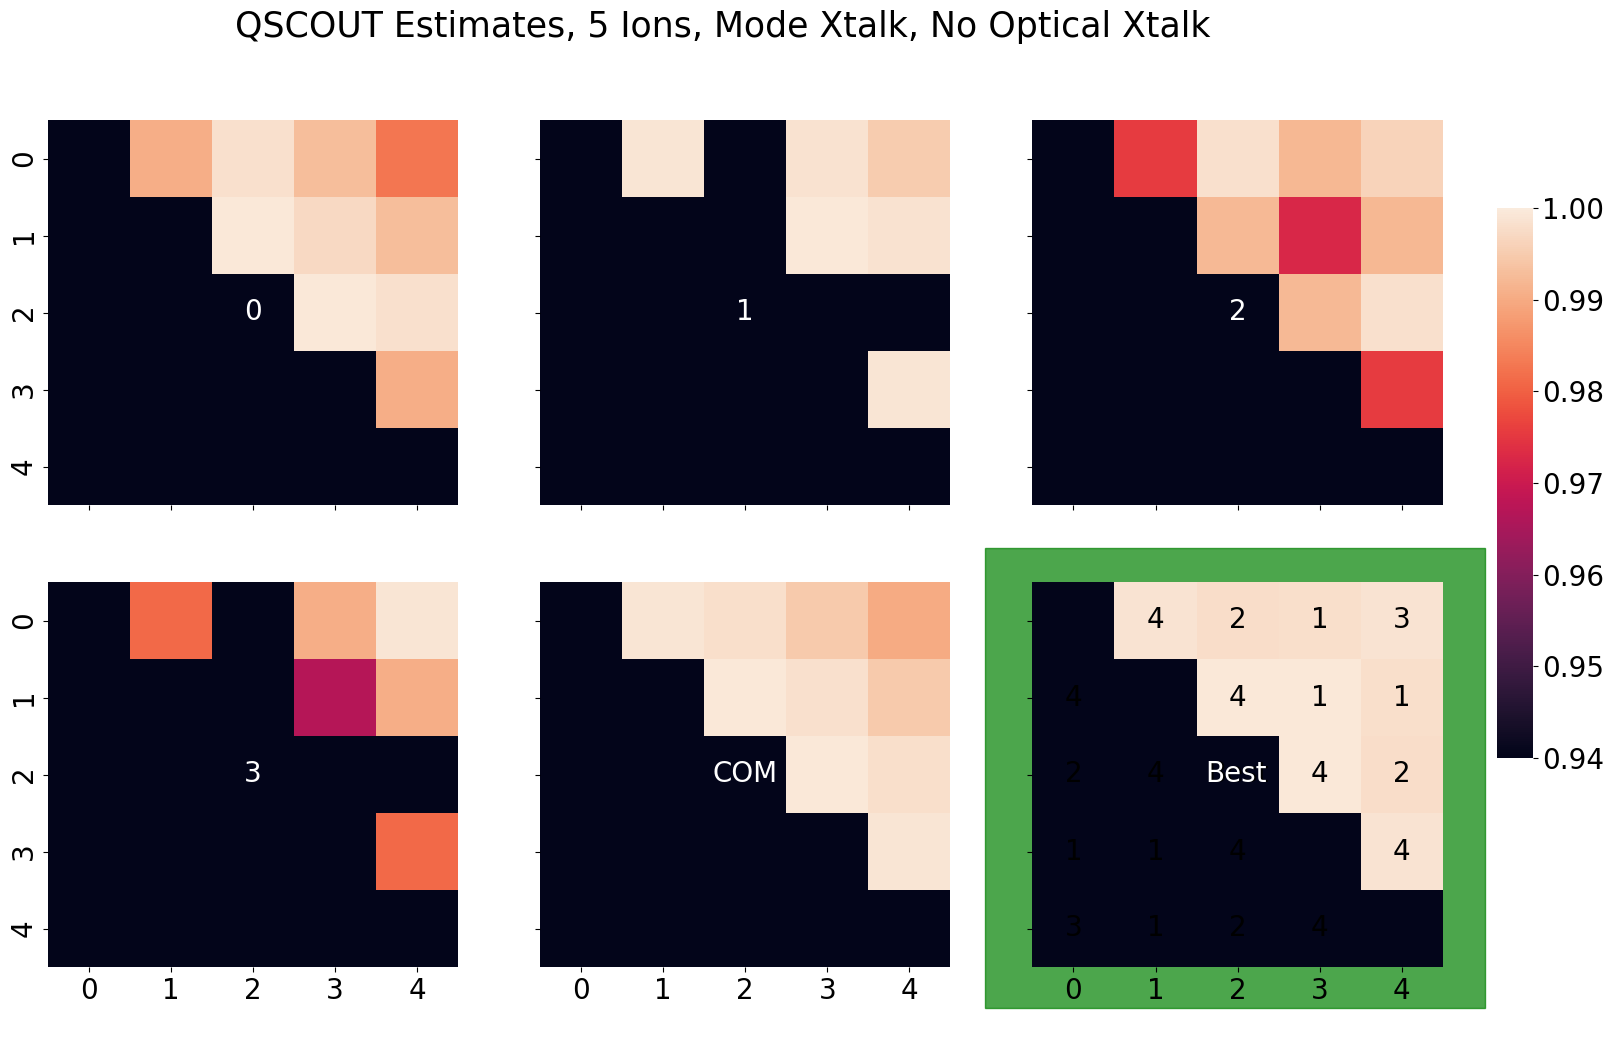

In [39]:
file = open('calculated_results/qscout_5ion_fidelities_withoutopticalxtalk_withmodextalk', "r")
fids = [MSFidCalculation.fromDict(ast.literal_eval(line)) for line in file.readlines()]
fidarr = np.zeros((N,N,N))
for fidcalc in fids:
    if fidcalc.fidions == fidcalc.opspec.targets:
        targets = fidcalc.opspec.targets
        m = fidcalc.opspec.m
        fidarr[targets[0],targets[1],m] = fidcalc.fid
plotBestModes(N, fidarr, title="QSCOUT Estimates, 5 Ions, Mode Xtalk, No Optical Xtalk")

## Side Test: Consider spectator contributions in laser rabi freq calculation

In [ ]:
# def calc_necessary_sideband_detuning_and_rabi_freq_allmodecontrib(devicespec, targets, m, modetype, τ, K=1):
#     δ = 2*π*K/τ # Detuning is restricted by requirement to close phase-space loop
#     νm = devicespec.modes(modetype)[m].freq
#     ηki = lambda k, i : devicespec.LDparam(k, modetype, i)
#     pairηeff = 0
#     for k in range(N):
#         pairηeff += ηki(k,targets[0])*ηki(k,targets[1])/(δ+νm-devicespec.modes(modetype)[k].freq)
#     Ω = np.sqrt(δ/abs(4*K*pairηeff)) # Single rabi freq, meant for both target ions
#     return νm+δ, Ω

## Simulated Parity Curves

### Example

/home/vikk/Documents/Research/sqrlab/MS Modes/pythonquantumenv/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/vikk/Documents/Research/sqrlab/MS Modes/pythonquantumenv/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


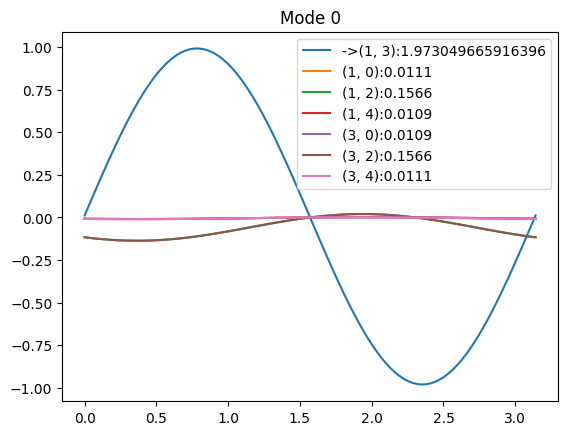

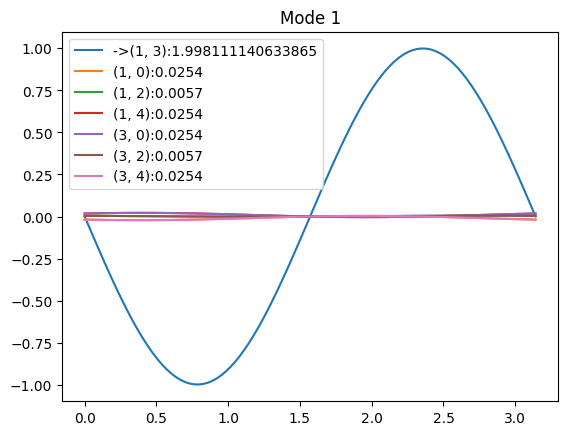

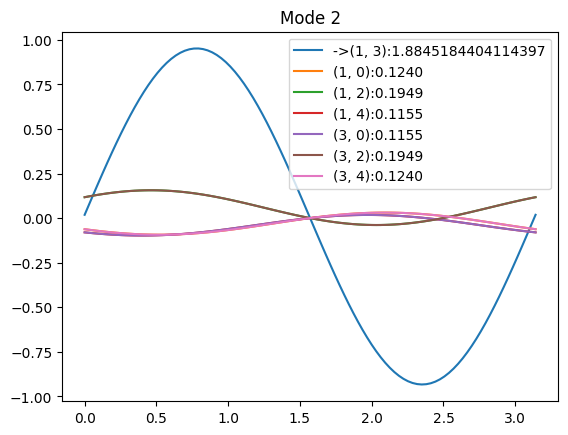

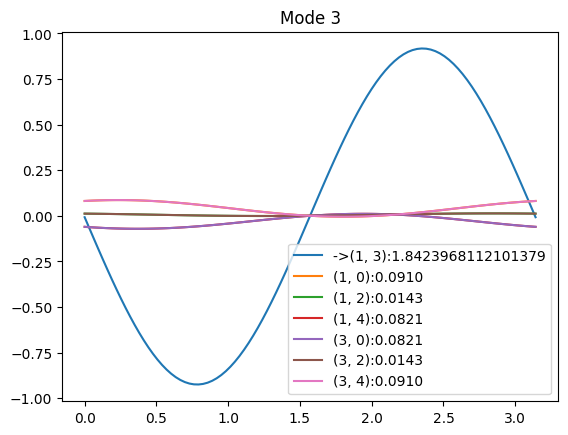

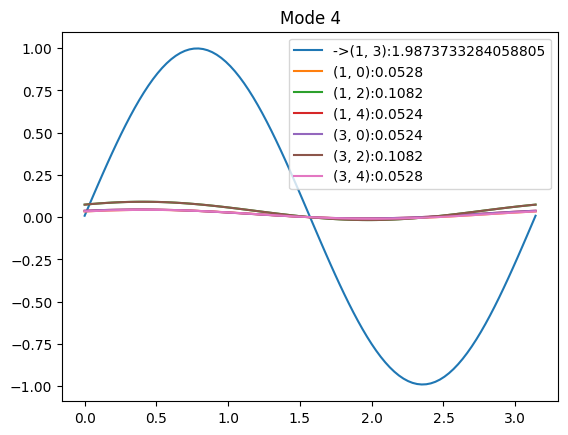

In [42]:
targets = (1,3)
for m in range(N):
    ωd, Ω = calc_necessary_sideband_detuning_and_rabi_freq(devicespec, targets, m, modetype, τ, K=K)
    Ωvals = Ω*Ωvals_from_fixed_neighbor_xtalk(N, targets, neighΩ, nneighΩ)
    mslaserspec = MSLaserSpec(ωd, Ωvals, ϕB, ϕR)
    msopspec = MSOpSpec(devicespec, mslaserspec, τ, targets=targets, m=m, modetype=modetype, K=K)
    ρf = MS_Analytical_zeroinitalstate_tracemodes(msopspec, simmodes=[0,1,2,3,4],modetype=modetype, modetrunc=2)
    neighbors = [i for i in range(N) if i in [targets[0]-1,targets[0]+1,targets[1]-1,targets[1]+1] and i not in targets]
    plt.figure()
    ρred = ρf.ptrace(targets)
    paritycurve = parityCurve(ρred)
    amplitude = abs(np.max(paritycurve.T[1])-np.min(paritycurve.T[1]))
    plt.plot(*paritycurve.T, label=f"->{targets}:{amplitude}")
    for t in targets:
        for n in neighbors:
            ρred = ρf.ptrace((t,n))
            paritycurve = parityCurve(ρred)
            amplitude = abs(np.max(paritycurve.T[1])-np.min(paritycurve.T[1]))
            plt.plot(*paritycurve.T, label=f"{(t,n)}:{amplitude:.4f}")
    plt.legend()
    plt.title(f"Mode {m}")